In [1]:
import os
from glob import glob
import math
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Patch, Rectangle

import matplotlib

import geopandas as gpd

import pandas as pd

import scalebar

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from skimage import exposure

from shapely import geometry

import json

import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling, array_bounds

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import seaborn as sns

%matplotlib inline

# Map of Colorado ASO Performance

In [2]:
root = '/Volumes/wrangell-st-elias/research/planet/CO/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-2020-01-21-21-37-55-126:planet-snowcover-imagery:20180524_172637_0f2d_3B_AnalyticMS_SR_clip/'

In [3]:
imagepath = root.split("/")[-2].split(":")[-1]
print(imagepath)

20180524_172637_0f2d_3B_AnalyticMS_SR_clip


In [4]:
mask_ds = rio.open(glob(os.path.join(root, "mask/*merged*.tif"))[0])
mask_data = mask_ds.read(1, masked=True)
nozero_mask = np.ma.masked_array(mask_data, mask_data == 0)

In [5]:
extent = [mask_ds.bounds[0], mask_ds.bounds[2], mask_ds.bounds[1], mask_ds.bounds[3]]
extent

[-107.127685546875, -106.995849609375, 39.01918781175702, 39.087436032158834]

In [6]:
nir_image = rio.open(glob(os.path.join(root, "*clip.tif"))[0])


In [7]:
data_region = gpd.read_file(os.path.join(root, "data-mask.geojson"))

In [8]:
def plot_mask(mask, extent, ax, cmap, alpha=1):
    
    im = ax.imshow(mask, extent=extent, transform=ccrs.PlateCarree(), origin='upper', vmin=0.5, vmax = 1, cmap=cmap, alpha=alpha)
    gl = ax.gridlines(crs=ccrs.PlateCarree(),
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--', draw_labels=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabels_top = False
    gl.ylabels_right = False

    
def plot_diff(mask, pred, extent, ax, alpha=1):
    diff = mask - pred
    im = ax.imshow(diff, extent=extent, transform=ccrs.PlateCarree(), origin='upper', vmin=-1, vmax=1, cmap='RdBu', alpha=alpha)
    gl = ax.gridlines(crs=ccrs.PlateCarree(),
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--', draw_labels=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabels_top = False
    gl.ylabels_right = False
    return(im)


In [9]:
nodata_diff = geometry.Polygon.from_bounds(*mask_ds.bounds).difference(data_region.geometry.iloc[0])

In [10]:
extent

[-107.127685546875, -106.995849609375, 39.01918781175702, 39.087436032158834]

In [11]:
nir_image = rio.open(glob(os.path.join(root, "*clip.tif"))[0])

nir_reproject = None
ndsi_reproject = None
with nir_image as src:
    transform, width, height = calculate_default_transform(
        src.crs, "EPSG:4326", src.width, src.height, *src.bounds)

    
    green = src.read(2, masked=True) 
    NIR = src.read(4, masked=True) 
    ndsi = (green - NIR) / (green + NIR)
    
    ndsi_reproject = np.zeros((height, width), dtype=float)

    reproject(
        source=ndsi / 10000,
        src_nodata=src.nodata, 
        dst_nodata=src.nodata,
        destination=ndsi_reproject,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=transform,
        dst_crs="EPSG:4326",
        resampling=Resampling.nearest)

    nir_reproject = np.zeros((height, width), dtype=float)
    reproject(
        source=src.read(4) / 10000,
        src_nodata=src.nodata, 
        dst_nodata=src.nodata,
        destination=nir_reproject,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=transform,
        dst_crs="EPSG:4326",
        resampling=Resampling.nearest)
    
    nir_reproject = np.ma.masked_array(nir_reproject, nir_reproject == src.nodata)
    bounds = array_bounds(height, width, transform)
    image_reproject_extent = [bounds[0], bounds[2], bounds[1], bounds[3]]


In [12]:
pred_ds = rio.open(glob(os.path.join(root, "preds/*merged*.tif"))[0])
pred_data = pred_ds.read(1, masked=True)
nozero_pred = np.ma.masked_array(pred_data, pred_data == 0)

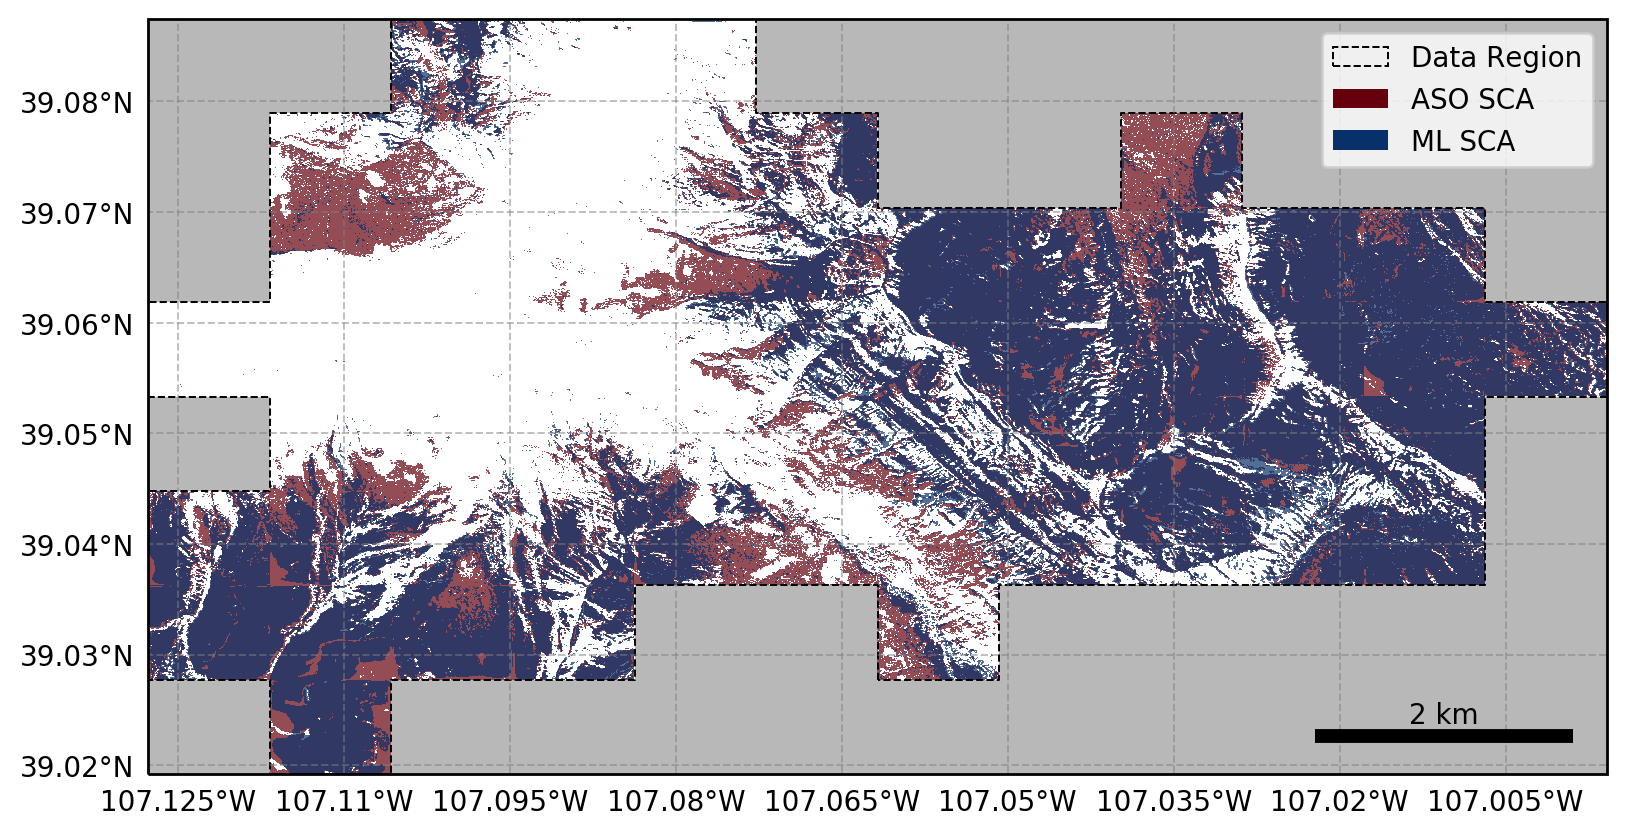

In [13]:
fig = plt.figure(figsize=(10,5), dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_geometries([nodata_diff], crs=ccrs.PlateCarree(), facecolor='gray', alpha=0.1)

cmap_mask = plt.cm.get_cmap("Reds", 2)
cmap_pred = plt.cm.get_cmap("Blues", 2)
# rgb = np.moveaxis(adjusted_rgb, 0, 2)

# ax.imshow(exposure.equalize_hist(nir_reproject.data), extent=image_reproject_extent, transform=ccrs.PlateCarree(), origin ='upper', cmap='binary')
# ax.imshow(np.moveaxis(exposure.equalize_hist(rgb_reproject), 0, 2), extent=image_reproject_extent, transform=ccrs.PlateCarree(), origin ='upper', cmap='binary')


# plot_mask(nozero_mask, extent, ax, cmap=cmap, alpha=0.9)

im = ax.imshow(nozero_mask, extent=extent, transform=ccrs.PlateCarree(), origin='upper', vmin=0.5, vmax = 1, cmap=cmap_mask, alpha=0.7)
im = ax.imshow(nozero_pred, extent=extent, transform=ccrs.PlateCarree(), origin='upper', vmin=0.5, vmax = 1, cmap=cmap_pred, alpha=0.7)

gl = ax.gridlines(crs=ccrs.PlateCarree(),
                  linewidth=0.7, color='gray', alpha=0.5, linestyle='--', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False




ax.add_geometries([nodata_diff], crs=ccrs.PlateCarree(), facecolor='gray', alpha=0.5)


ax.add_geometries(data_region.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7)
legendParts = [
    (Patch(facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7, label='Data Region')), 
    (Patch(facecolor=cmap_mask(1), label='ASO SCA')), 
    (Patch(facecolor=cmap_pred(1), label='ML SCA'))
]

scalebar.scale_bar(ax, (0.8, 0.05), 2, linewidth=5, text_offset=0.009, plot_kwargs={"solid_capstyle": 'butt'})


ax.legend(handles=legendParts)

# ax.text(0.01, 0.02, "Includes material © 2020 Planet Labs Inc. All Rights Reserved.".format("_".join(imagepath.split('_')[:3])), transform=ax.transAxes, fontdict={'color': 'white', 'fontsize' : 7})

ax.set_extent(extent, crs=ccrs.PlateCarree())
plt.savefig("test_image.png")

## Plot with additional barplots

In [14]:
# from `model-comparison.ipynb`
metrics = pd.read_csv(os.path.join(root, "comparator", "all_metrics.csv"))
metrics

Unnamed: 0              SCA           variable     value
0            0       CubeSat ML              index  0.000000
1            1  Sentinel 2 NDSI              index  0.000000
2            2   Landsat 8 fSCA              index  0.000000
3            3       CubeSat ML          Precision  0.906913
4            4  Sentinel 2 NDSI          Precision  0.955908
5            5   Landsat 8 fSCA          Precision  0.809972
6            6       CubeSat ML             Recall  0.735509
7            7  Sentinel 2 NDSI             Recall  0.746228
8            8   Landsat 8 fSCA             Recall  0.943152
9            9       CubeSat ML            F-Score  0.812267
10          10  Sentinel 2 NDSI            F-Score  0.838153
11          11   Landsat 8 fSCA            F-Score  0.871503
12          12       CubeSat ML  Balanced Accuracy  0.824009
13          13  Sentinel 2 NDSI  Balanced Accuracy  0.853146
14          14   Landsat 8 fSCA  Balanced Accuracy  0.843344
15          15       CubeSat ML              Kappa  0.638431
16          16  Sentinel 2 NDSI              Kappa  0.694093
17          17   Landsat 8 fSCA              Kappa  0.695786

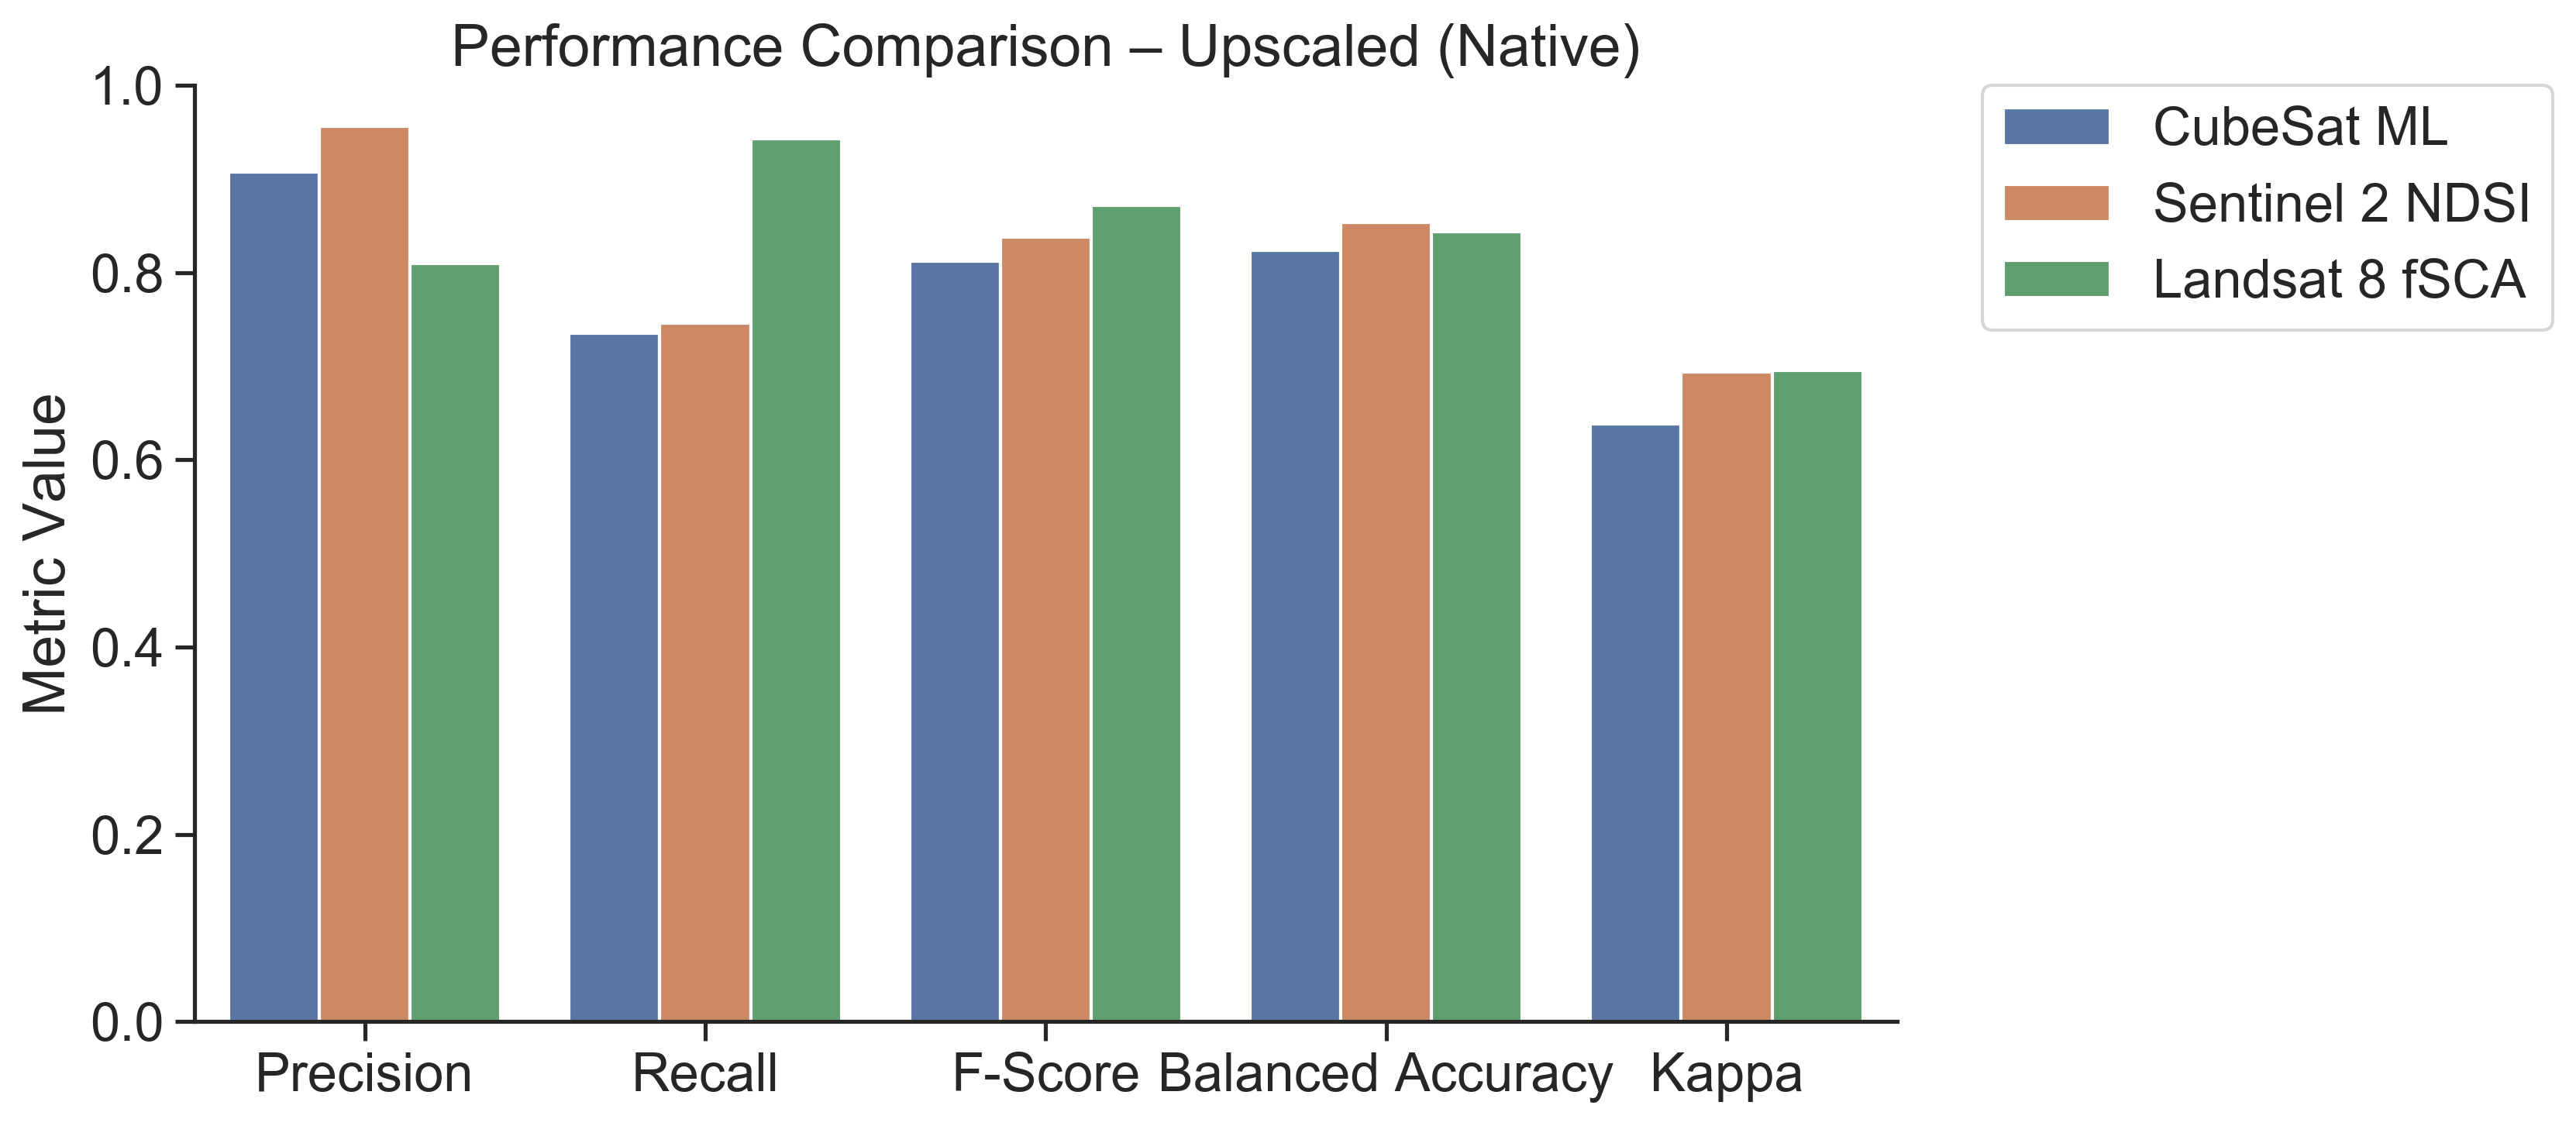

In [15]:

sns.set(style='ticks', font_scale=1.5)

fig, ax = plt.subplots(figsize=(11.5,5), dpi=300)
bp = sns.barplot(x='variable', hue='SCA', y = 'value', data=metrics, ax= ax, order=['Precision', "Recall", "F-Score", "Balanced Accuracy", "Kappa"])
plt.ylim([0, 1])
plt.xlabel("")
plt.ylabel("Metric Value")
# ax.yaxis.set_minor_locator(AutoMinorLocator(2))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
plt.tight_layout()
plt.title("Performance Comparison – Upscaled (Native)")
plt.savefig("performance.png", dpi=300, bbox_inches='tight')


# test_results = add_stat_annotation(ax, data=melted2, x='variable', y='value', hue='SCA',
#                                    box_pairs=box_pairs,
#                                    test='t-test_ind', text_format='star',
#                                    loc='outside', verbose=2)
# plt.savefig("tuol-sentinel-ml-performance_sig.png", dpi=300, bbox_inches='tight')

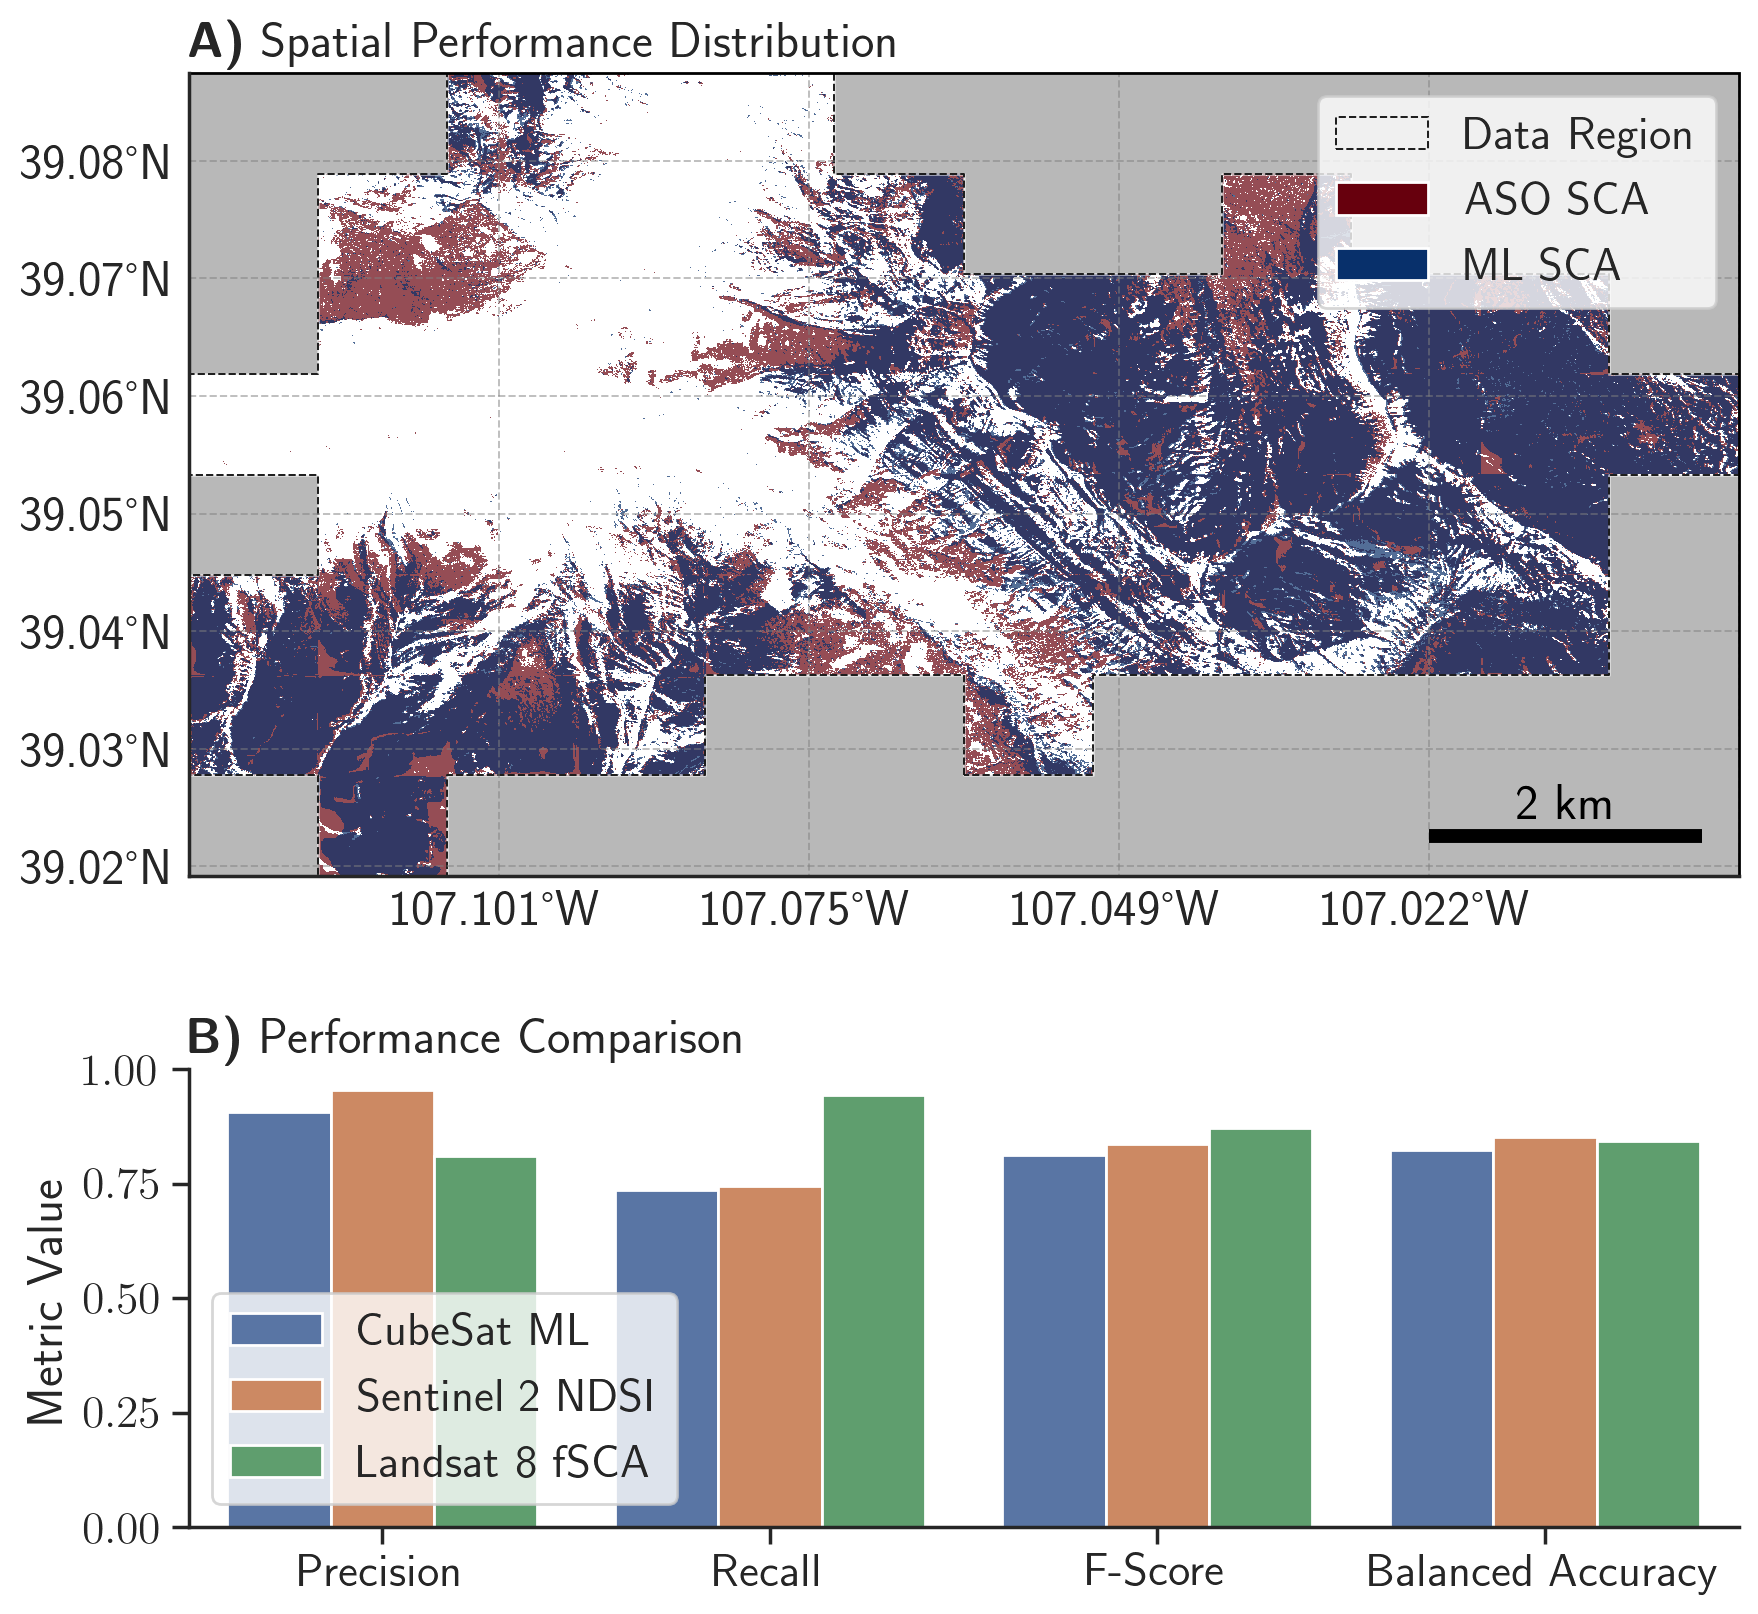

In [56]:
plt.rc('text', usetex=True)

fig = plt.figure(figsize=(10,10), dpi=200)
grid = fig.add_gridspec(2, 1, height_ratios=[4,2])

ax = fig.add_subplot(grid[0], projection=ccrs.PlateCarree())
ax.add_geometries([nodata_diff], crs=ccrs.PlateCarree(), facecolor='gray', alpha=0.1)

cmap_mask = plt.cm.get_cmap("Reds", 2)
cmap_pred = plt.cm.get_cmap("Blues", 2)
# rgb = np.moveaxis(adjusted_rgb, 0, 2)

# ax.imshow(exposure.equalize_hist(nir_reproject.data), extent=image_reproject_extent, transform=ccrs.PlateCarree(), origin ='upper', cmap='binary')
# ax.imshow(np.moveaxis(exposure.equalize_hist(rgb_reproject), 0, 2), extent=image_reproject_extent, transform=ccrs.PlateCarree(), origin ='upper', cmap='binary')


im = ax.imshow(nozero_mask, extent=extent, transform=ccrs.PlateCarree(), origin='upper', vmin=0.5, vmax = 1, cmap=cmap_mask, alpha=0.7)
im = ax.imshow(nozero_pred, extent=extent, transform=ccrs.PlateCarree(), origin='upper', vmin=0.5, vmax = 1, cmap=cmap_pred, alpha=0.7)


gl = ax.gridlines(crs=ccrs.PlateCarree(),
                  linewidth=0.7, color='gray', alpha=0.5, linestyle='--', draw_labels=True, xlocs=np.linspace(extent[0], extent[1], 6))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False




ax.add_geometries([nodata_diff], crs=ccrs.PlateCarree(), facecolor='gray', alpha=0.5)


ax.add_geometries(data_region.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7)
legendParts = [
    (Patch(facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7, label='Data Region')), 
    (Patch(facecolor=cmap_mask(1), label='ASO SCA')), 
    (Patch(facecolor=cmap_pred(1), label='ML SCA'))
]

ax.legend(handles=legendParts)
ax.set_title(r"\textbf{A)}" + " Spatial Performance Distribution", loc='left')



scalebar.scale_bar(ax, (0.8, 0.05), 2, linewidth=5, text_offset=0.009, plot_kwargs={"solid_capstyle": 'butt'})


# ax.text(0.01, 0.02, "Includes material © 2020 Planet Labs Inc. All Rights Reserved.".format("_".join(imagepath.split('_')[:3])), transform=ax.transAxes, fontdict={'color': 'white', 'fontsize' : 7})

ax.set_extent(extent, crs=ccrs.PlateCarree())

ax_bars = fig.add_subplot(grid[1])


sns.set(style='ticks', font_scale=1.5)

bp = sns.barplot(x='variable', hue='SCA', y = 'value', data=metrics, ax=ax_bars, order=['Precision', "Recall", "F-Score", "Balanced Accuracy"])
ax_bars.set_ylim([0, 1])
ax_bars.set_xlabel("")
ax_bars.set_ylabel("Metric Value")
# ax.yaxis.set_minor_locator(AutoMinorLocator(2))
# ax_bars.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
# ax_bars.tight_layout()
ax_bars.set_title(r"\textbf{B)}" + " Performance Comparison", loc='left')

ax_bars.legend(loc='lower left')

# test_results = add_stat_annotation(ax, data=melted2, x='variable', y='value', hue='SCA',
#                                    box_pairs=box_pairs,
#                                    test='t-test_ind', text_format='star',
#                                    loc='outside', verbose=2)
# plt.savefig("tuol-sentinel-ml-performance_sig.png", dpi=300, bbox_inches='tight')

plt.savefig(f"{imagepath}_combo_image.png", dpi=300, bbox_inches='tight', transparent=True)

## Add Visual Asset, since we have it

In [60]:
visual = glob(os.path.join(root, "*Visual.tif"))
if len(visual) > 0:
    visual = visual[0]

In [126]:



visual_reproject = None
with rio.open(visual) as src:
    transform, width, height = calculate_default_transform(
        src.crs, "EPSG:4326", src.width, src.height, *src.bounds)
    
    visual_reproject = np.zeros((src.count, height, width), dtype=float)


    for band in range(1, src.count + 1):
        reproject(
            source=src.read(band),
            src_nodata=src.nodata, 
            dst_nodata=src.nodata,
            destination=visual_reproject[band - 1, :, :],
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs="EPSG:4326",
            resampling=Resampling.nearest)

    visual_reproject = np.ma.masked_array(visual_reproject, visual_reproject == src.nodata).astype('int')
    bounds = array_bounds(height, width, transform)
    visual_reproject_extent = [bounds[0], bounds[2], bounds[1], bounds[3]]


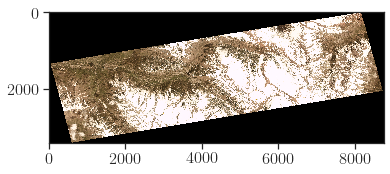

In [125]:
plt.imshow(np.stack([
    visual_reproject[0], 
    visual_reproject[1],
    visual_reproject[2]
], axis=-1))

In [123]:
visual_reproject.astype(int)

masked_array(
  data=[[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]],
  mask=[[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False

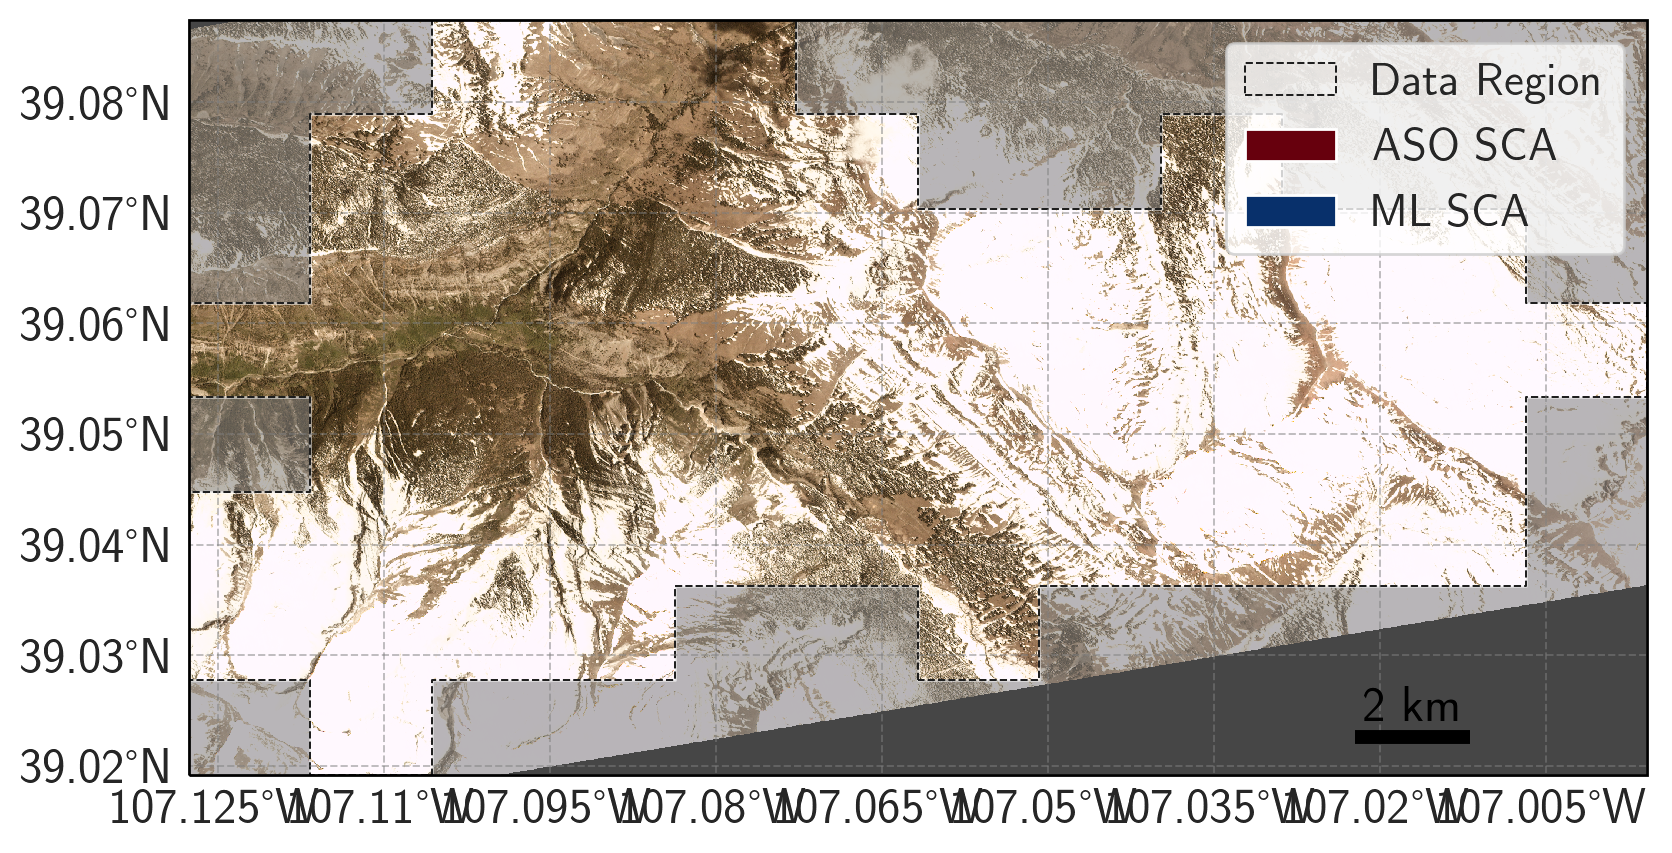

In [127]:
fig = plt.figure(figsize=(10,5), dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_geometries([nodata_diff], crs=ccrs.PlateCarree(), facecolor='gray', alpha=0.1)

cmap_mask = plt.cm.get_cmap("Reds", 2)
cmap_pred = plt.cm.get_cmap("Blues", 2)
# rgb = np.moveaxis(adjusted_rgb, 0, 2)

# ax.imshow(exposure.equalize_hist(nir_reproject.data), extent=image_reproject_extent, transform=ccrs.PlateCarree(), origin ='upper', cmap='binary')
# ax.imshow(np.moveaxis(exposure.equalize_hist(rgb_reproject), 0, 2), extent=image_reproject_extent, transform=ccrs.PlateCarree(), origin ='upper', cmap='binary')


# plot_mask(nozero_mask, extent, ax, cmap=cmap, alpha=0.9)

ax.imshow(np.stack([
    visual_reproject[0], 
    visual_reproject[1],
    visual_reproject[2]
], axis=-1), extent=visual_reproject_extent, transform=ccrs.PlateCarree(), origin='upper')
# im = ax.imshow(nozero_mask, extent=extent, transform=ccrs.PlateCarree(), origin='upper', vmin=0.5, vmax = 1, cmap=cmap_mask, alpha=0.7)
# im = ax.imshow(nozero_pred, extent=extent, transform=ccrs.PlateCarree(), origin='upper', vmin=0.5, vmax = 1, cmap=cmap_pred, alpha=0.7)

gl = ax.gridlines(crs=ccrs.PlateCarree(),
                  linewidth=0.7, color='gray', alpha=0.5, linestyle='--', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False




ax.add_geometries([nodata_diff], crs=ccrs.PlateCarree(), facecolor='gray', alpha=0.5)


ax.add_geometries(data_region.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7)
legendParts = [
    (Patch(facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7, label='Data Region')), 
    (Patch(facecolor=cmap_mask(1), label='ASO SCA')), 
    (Patch(facecolor=cmap_pred(1), label='ML SCA'))
]

scalebar.scale_bar(ax, (0.8, 0.05), 2, linewidth=5, text_offset=0.009, plot_kwargs={"solid_capstyle": 'butt'})


ax.legend(handles=legendParts)

# ax.text(0.01, 0.02, "Includes material © 2020 Planet Labs Inc. All Rights Reserved.".format("_".join(imagepath.split('_')[:3])), transform=ax.transAxes, fontdict={'color': 'white', 'fontsize' : 7})

ax.set_extent(extent, crs=ccrs.PlateCarree())
plt.savefig("test_image.png")

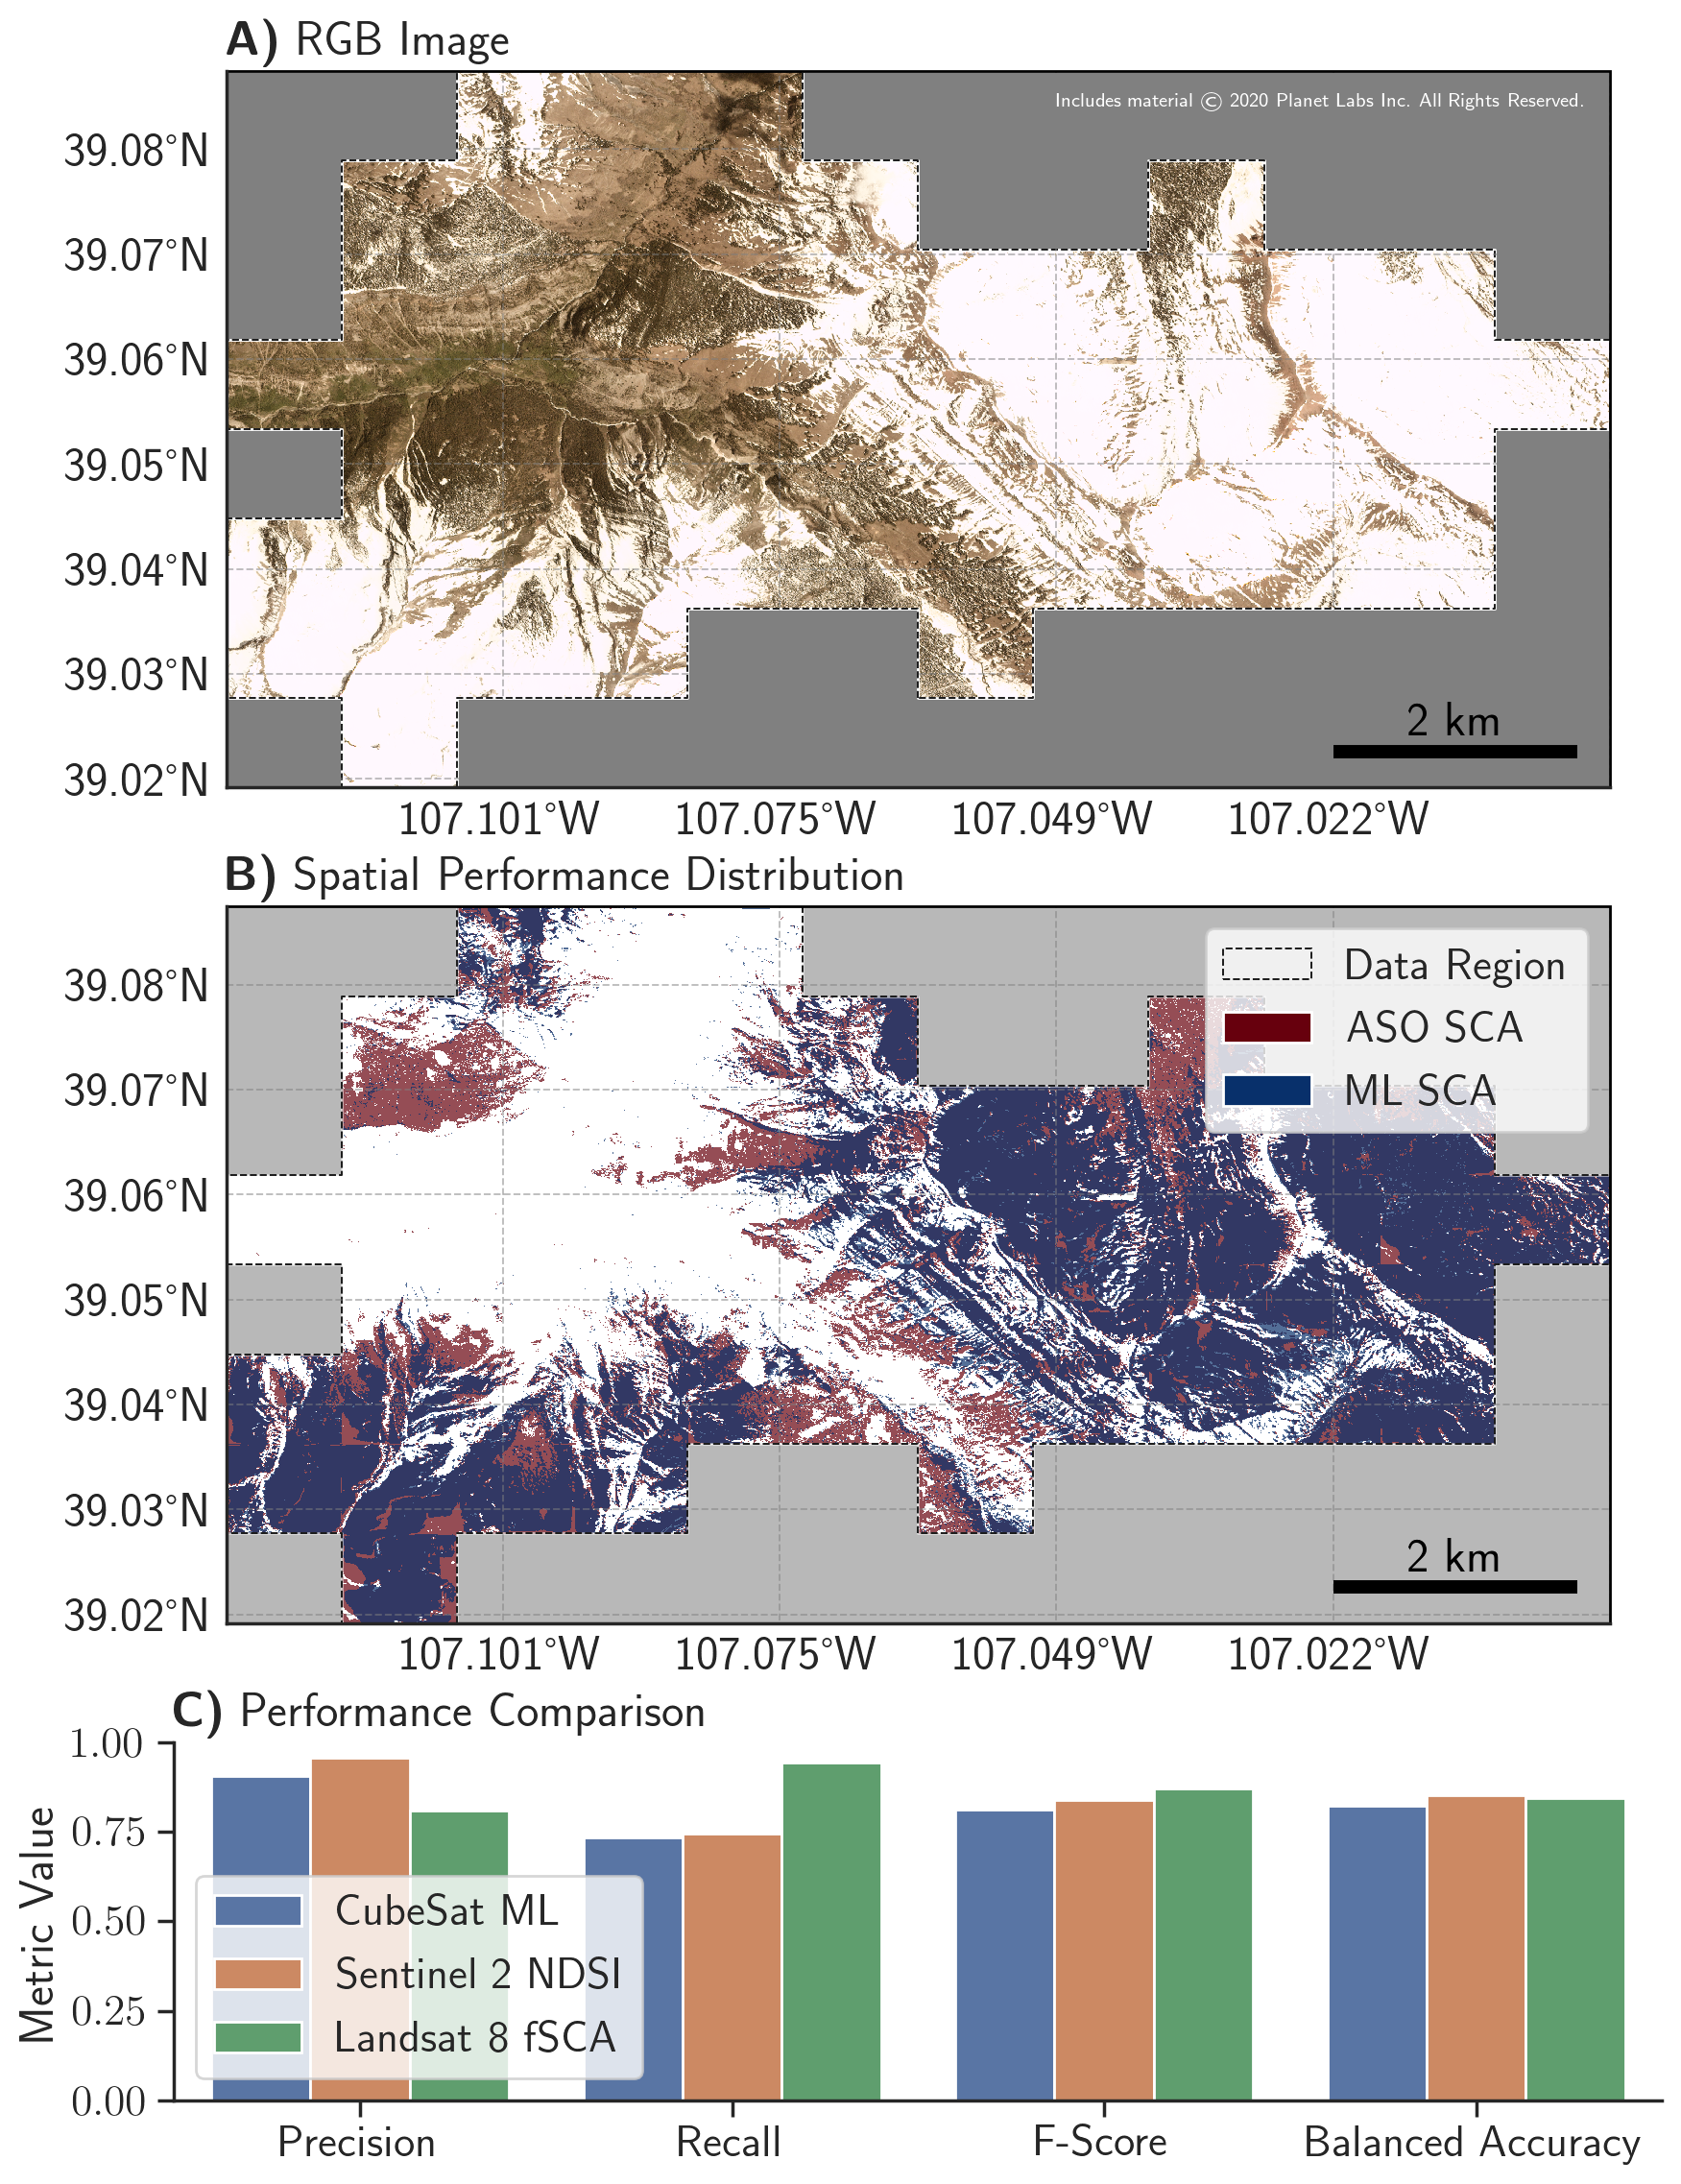

In [135]:
plt.rc('text', usetex=True)

fig = plt.figure(figsize=(10,14), dpi=200)
grid = fig.add_gridspec(3, 1, height_ratios=[4, 4, 2])


ax = fig.add_subplot(grid[0], projection=ccrs.PlateCarree())
ax.imshow(np.stack([
    visual_reproject[0], 
    visual_reproject[1],
    visual_reproject[2]
], axis=-1), extent=visual_reproject_extent, transform=ccrs.PlateCarree(), origin='upper')
ax.add_geometries([nodata_diff], crs=ccrs.PlateCarree(), facecolor='gray', alpha=1)
ax.text(0.6, 0.95, "Includes material © 2020 Planet Labs Inc. All Rights Reserved.".format("_".join(imagepath.split('_')[:3])), transform=ax.transAxes, fontdict={'color': 'white', 'fontsize' : 7})


ax.add_geometries(data_region.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7)

gl = ax.gridlines(crs=ccrs.PlateCarree(),
                  linewidth=0.7, color='gray', alpha=0.5, linestyle='--', draw_labels=True, xlocs=np.linspace(extent[0], extent[1], 6))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.set_title(r"\textbf{A)}" + " RGB Image", loc='left')
scalebar.scale_bar(ax, (0.8, 0.05), 2, linewidth=5, text_offset=0.009, plot_kwargs={"solid_capstyle": 'butt'})



ax = fig.add_subplot(grid[1], projection=ccrs.PlateCarree())
ax.add_geometries([nodata_diff], crs=ccrs.PlateCarree(), facecolor='gray', alpha=0.1)

cmap_mask = plt.cm.get_cmap("Reds", 2)
cmap_pred = plt.cm.get_cmap("Blues", 2)
# rgb = np.moveaxis(adjusted_rgb, 0, 2)

# ax.imshow(exposure.equalize_hist(nir_reproject.data), extent=image_reproject_extent, transform=ccrs.PlateCarree(), origin ='upper', cmap='binary')
# ax.imshow(np.moveaxis(exposure.equalize_hist(rgb_reproject), 0, 2), extent=image_reproject_extent, transform=ccrs.PlateCarree(), origin ='upper', cmap='binary')


im = ax.imshow(nozero_mask, extent=extent, transform=ccrs.PlateCarree(), origin='upper', vmin=0.5, vmax = 1, cmap=cmap_mask, alpha=0.7)
im = ax.imshow(nozero_pred, extent=extent, transform=ccrs.PlateCarree(), origin='upper', vmin=0.5, vmax = 1, cmap=cmap_pred, alpha=0.7)


gl = ax.gridlines(crs=ccrs.PlateCarree(),
                  linewidth=0.7, color='gray', alpha=0.5, linestyle='--', draw_labels=True, xlocs=np.linspace(extent[0], extent[1], 6))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False




ax.add_geometries([nodata_diff], crs=ccrs.PlateCarree(), facecolor='gray', alpha=0.5)


ax.add_geometries(data_region.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7)
legendParts = [
    (Patch(facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7, label='Data Region')), 
    (Patch(facecolor=cmap_mask(1), label='ASO SCA')), 
    (Patch(facecolor=cmap_pred(1), label='ML SCA'))
]

ax.legend(handles=legendParts)
ax.set_title(r"\textbf{B)}" + " Spatial Performance Distribution", loc='left')



scalebar.scale_bar(ax, (0.8, 0.05), 2, linewidth=5, text_offset=0.009, plot_kwargs={"solid_capstyle": 'butt'})


# ax.text(0.01, 0.02, "Includes material © 2020 Planet Labs Inc. All Rights Reserved.".format("_".join(imagepath.split('_')[:3])), transform=ax.transAxes, fontdict={'color': 'white', 'fontsize' : 7})

ax.set_extent(extent, crs=ccrs.PlateCarree())

ax_bars = fig.add_subplot(grid[2])


sns.set(style='ticks', font_scale=1.5)

bp = sns.barplot(x='variable', hue='SCA', y = 'value', data=metrics, ax=ax_bars, order=['Precision', "Recall", "F-Score", "Balanced Accuracy"])
ax_bars.set_ylim([0, 1])
ax_bars.set_xlabel("")
ax_bars.set_ylabel("Metric Value")
# ax.yaxis.set_minor_locator(AutoMinorLocator(2))
# ax_bars.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
# ax_bars.tight_layout()
ax_bars.set_title(r"\textbf{C)}" + " Performance Comparison", loc='left')

ax_bars.legend(loc='lower left')

# test_results = add_stat_annotation(ax, data=melted2, x='variable', y='value', hue='SCA',
#                                    box_pairs=box_pairs,
#                                    test='t-test_ind', text_format='star',
#                                    loc='outside', verbose=2)
# plt.savefig("tuol-sentinel-ml-performance_sig.png", dpi=300, bbox_inches='tight')

plt.savefig(f"{imagepath}_combo_image.png", dpi=300, bbox_inches='tight', transparent=False)